## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [ ]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

In [ ]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [ ]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [ ]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [ ]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [ ]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

In [ ]:
# save the data set

data.to_csv('titanic.csv', index=False)

In [2]:
## read final dataframe
data = pd.read_csv("titanic.csv")

## Data Exploration

### Find numerical and categorical variables

In [3]:
target = 'survived'

In [4]:
## seeing dtypes
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

In [5]:
vars_cat = data.select_dtypes(include='object').columns.to_list()

vars_num = [col for col in data.columns if col not in vars_cat]


print('Number of numerical variables: {}'.format(len(vars_num)))
print('Numerical vars: ', vars_num)
print('Number of categorical variables: {}'.format(len(vars_cat)))
print('Categorical vars: ',vars_cat)



Number of numerical variables: 6
Numerical vars:  ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']
Number of categorical variables: 4
Categorical vars:  ['sex', 'cabin', 'embarked', 'title']


### Find missing values in variables

In [6]:
# first in numerical variables

## see if numeric values have nulls
data[vars_num].isnull().sum()/data.shape[0]

pclass      0.000000
survived    0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
dtype: float64

Age and Fare, in the numeric values, are the ones with missing values. This can be replace by the mode or median. 

In [7]:
# now in categorical variables

data[vars_cat].isnull().sum()/data.shape[0]

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

So, most of missing values in the continous variables are in the cabin category. Embarked has missing values too but is below 5% so this values can be exclued.

### Determine cardinality of categorical variables

In [8]:
card_vars_cat = {col:len(set(data[col])) for col in vars_cat}
print(card_vars_cat)

{'sex': 2, 'cabin': 182, 'embarked': 4, 'title': 5}


### Determine the distribution of numerical variables

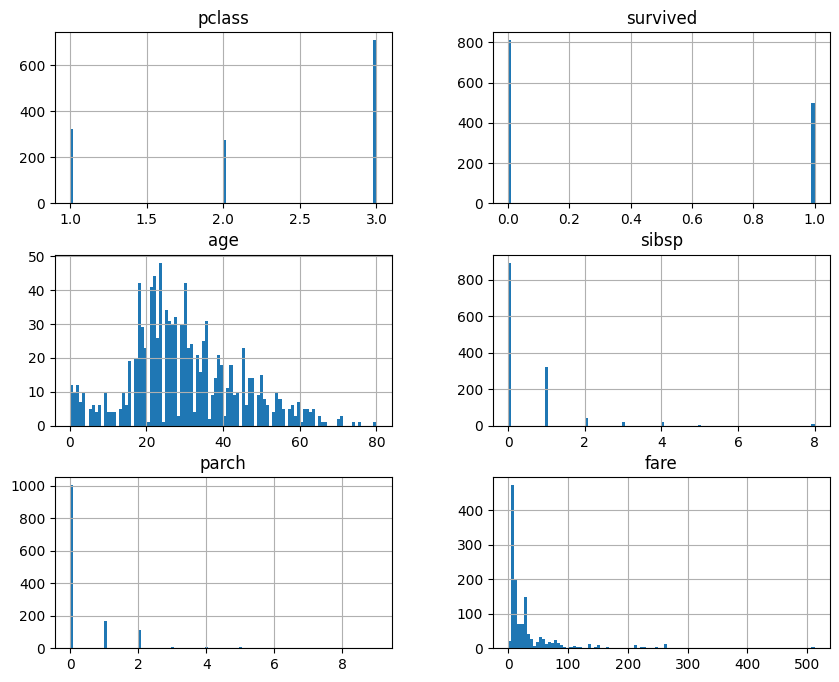

In [9]:
data[vars_num].hist(bins=100,figsize=(10,8));


We can see that parch, pclass, survived, sibsp are all discrete variables. With parch and sibsp being very unbalanced
Fare and age are continous with his distributions very skewed. Maybe by applying transformations makes them look more a like normal distribuition.

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [32]:
def search_letter(value):
    try:
        return re.match(pattern=r'([aA-zZ]+)',string=value).group(1)
    except:
        return np.nan

vsearch_letter = np.vectorize(search_letter,otypes=['object'])

# remove letters from cabin column
clean_values_train = vsearch_letter(X_train['cabin'].values)
clean_values_test = vsearch_letter(X_test['cabin'].values)


X_train.loc[:,'cabin'] = clean_values_train
X_test.loc[:,'cabin'] = clean_values_test

In [33]:
# verify the final cardinality
card_vars_cat_train = X_train[vars_cat].nunique().to_dict()
print('train:',card_vars_cat_train)

# verify the final cardinality
card_vars_cat_test = X_test[vars_cat].nunique().to_dict()
print('test:',card_vars_cat_test)

train: {'sex': 2, 'cabin': 8, 'embarked': 3, 'title': 5}
test: {'sex': 2, 'cabin': 7, 'embarked': 3, 'title': 5}


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [24]:
## remove 'survived' from var_num because it's our target and we don't need to treat it
vars_num.remove('survived')

ValueError: list.remove(x): x not in list

In [34]:
## find missing cols
def fill_missing_cols(null_cols):
    ## replace values 
    for col in null_cols:
        ## add binary missing indicator
        print(f'adding binary missing indicator for col {col}')
        X_train[f'{col}_is_nan'] = np.where(pd.isnull(X_train[col]).values,1,0)
        X_test[f'{col}_is_nan'] = np.where(pd.isnull(X_test[col]).values,1,0)
        
        ## fill na in original variable with the median
        median = X_train[col].median()
        print(f'input median value: {median} in column {col}')
        X_train.loc[:,col] = np.where(pd.isnull(X_train[col]).values,median,X_train[col])
        X_test.loc[:,col] = np.where(pd.isnull(X_test[col]).values,median,X_test[col])
   

null_cols = [col for col in vars_num if X_train[col].isnull().sum()>0]

#fill num missing cols in X_train and X_test
fill_missing_cols(null_cols)


adding binary missing indicator for col age
input median value: 28.0 in column age
adding binary missing indicator for col fare
input median value: 14.4542 in column fare


In [35]:
# checking null values 
print('Check null values in train')
print((X_train[vars_num].isnull().sum()/X_train.shape[0]).to_dict())
print('Check null values in test')
print((X_test[vars_num].isnull().sum()/X_test.shape[0]).to_dict())

Check null values in train
{'pclass': 0.0, 'age': 0.0, 'sibsp': 0.0, 'parch': 0.0, 'fare': 0.0}
Check null values in test
{'pclass': 0.0, 'age': 0.0, 'sibsp': 0.0, 'parch': 0.0, 'fare': 0.0}


### Replace Missing data in categorical variables with the string **Missing**

In [36]:
## find missing cols
def fill_cat_missing_cols(null_cols):
    ## replace values 
    for col in null_cols:
        ## fill na in original variable with the median
        X_train.loc[:,col] = np.where(pd.isnull(X_train[col]).values,'missing',X_train[col])
        X_test.loc[:,col] = np.where(pd.isnull(X_test[col]).values,'missing',X_test[col])

#fill cat missing cols in X_train
null_cols = [col for col in vars_cat if X_train[col].isnull().sum()>0]

# fill cat missing columns in X_train and X_test
fill_cat_missing_cols(null_cols)


In [37]:
# checking null values 
print('Check null values in train')
print((X_train[vars_cat].isnull().sum()/X_train.shape[0]).to_dict())
print('Check null values in test')
print((X_test[vars_cat].isnull().sum()/X_test.shape[0]).to_dict())

Check null values in train
{'sex': 0.0, 'cabin': 0.0, 'embarked': 0.0, 'title': 0.0}
Check null values in test
{'sex': 0.0, 'cabin': 0.0, 'embarked': 0.0, 'title': 0.0}


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [39]:
from collections import defaultdict

def find_rare_labels(dataframe,cat_labels,tolerance=0.05):
    rare_labels = defaultdict(list)
    qty_labels = {col:(dataframe[col].value_counts()/dataframe[col].shape[0]).to_dict() for col in cat_labels}
    for cat in qty_labels:
        for label,value in qty_labels[cat].items():
            if value < tolerance:
                rare_labels[cat].append(label)
    return rare_labels


# replace rare labels to 'Rare'
rare_labels = find_rare_labels(X_train,vars_cat)
for cat in rare_labels:
    X_train.loc[:,cat] = np.where(X_train[cat].isin(rare_labels[cat]),'Rare',X_train[cat])
    X_test.loc[:,cat] = np.where(X_test[cat].isin(rare_labels[cat]),'Rare',X_test[cat])

In [40]:
# verify the final cardinality
card_vars_cat_train = X_train[vars_cat].nunique().to_dict()
print('train:',card_vars_cat_train)

# verify the final cardinality
card_vars_cat_test = X_test[vars_cat].nunique().to_dict()
print('test:',card_vars_cat_test)

train: {'sex': 2, 'cabin': 3, 'embarked': 4, 'title': 4}
test: {'sex': 2, 'cabin': 3, 'embarked': 3, 'title': 4}


In [42]:
# Checking for embarked labels 
print('train labels: ',set(X_train['embarked']))
print('test labels: ', set(X_test['embarked']))

# we see that we don't have rare labels in test, will need to add this column later

train labels:  {'Rare', 'S', 'Q', 'C'}
test labels:  {'S', 'Q', 'C'}


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [43]:
for cat in vars_cat:
        # to create the binary variables, we use get_dummies from pandas
        X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[cat], prefix=cat, drop_first=True)
                         ], axis=1)
        X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[cat], prefix=cat, drop_first=True)
                        ], axis=1)


In [44]:
X_train = X_train.drop(labels=vars_cat, axis=1)
X_test = X_test.drop(labels=vars_cat, axis=1)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [45]:
print('train columns: ', X_train.columns)
print('test columns: ',X_test.columns)

train columns:  Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_is_nan', 'fare_is_nan',
       'sex_male', 'cabin_Rare', 'cabin_missing', 'embarked_Q',
       'embarked_Rare', 'embarked_S', 'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')
test columns:  Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_is_nan', 'fare_is_nan',
       'sex_male', 'cabin_Rare', 'cabin_missing', 'embarked_Q', 'embarked_S',
       'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')


In [46]:
# Creating embarked_Rare in test data 
X_test['embarked_Rare']=0

In [47]:
print('Check if we have equal columns in train and test: ')
print(set(X_test.columns)==set(X_train.columns))

print('Check for equal sizes in train sets: ')
print(X_train.shape[0]==y_train.shape[0])

print('Check for equal sizes in train sets: ')
print(X_test.shape[0]==y_test.shape[0])

Check if we have equal columns in train and test: 
True
Check for equal sizes in train sets: 
True
Check for equal sizes in train sets: 
True


In [48]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_is_nan,fare_is_nan,sex_male,cabin_Rare,cabin_missing,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,0,1,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,1,0,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,0,1,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,0,1,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,0,1,0,0,1,1,0,0


In [49]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_is_nan,fare_is_nan,sex_male,cabin_Rare,cabin_missing,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare,embarked_Rare
1139,3,38.0,0,0,7.8958,0,0,1,0,1,0,1,1,0,0,0
533,2,21.0,0,1,21.0000,0,0,0,0,1,0,1,0,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,0,1,0,1,1,0,0,0
1150,3,28.0,0,0,14.5000,1,0,1,0,1,0,1,1,0,0,0
393,2,25.0,0,0,31.5000,0,0,1,0,1,0,1,1,0,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [50]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [51]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_is_nan,fare_is_nan,sex_male,cabin_Rare,cabin_missing,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092,0.761042,-0.434076,0.551235,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092,-1.313987,2.303742,-1.814107,-0.319539,-0.043748,-1.563355,-1.149569,-0.435629,-0.275778
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,0.761042,-0.434076,0.551235,3.129507,-0.043748,-1.563355,0.869892,-0.435629,-0.275778
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092,-1.313987,-0.434076,0.551235,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092,0.761042,-0.434076,0.551235,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778


In [52]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_is_nan,fare_is_nan,sex_male,cabin_Rare,cabin_missing,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare,embarked_Rare
0,0.835808,0.665118,-0.478911,-0.455423,-0.505353,-0.494921,-0.03092,0.761042,-0.434076,0.551235,-0.319539,22.858259,0.639650,-1.149569,-0.435629,-0.275778
1,-0.353174,-0.688710,-0.478911,0.727773,-0.248980,-0.494921,-0.03092,-1.313987,-0.434076,0.551235,-0.319539,22.858259,-1.563355,-1.149569,-0.435629,-0.275778
2,-0.353174,0.983666,0.434422,-0.455423,-0.131595,-0.494921,-0.03092,0.761042,-0.434076,0.551235,-0.319539,22.858259,0.639650,-1.149569,-0.435629,-0.275778
3,0.835808,-0.131251,-0.478911,-0.455423,-0.376148,2.020526,-0.03092,0.761042,-0.434076,0.551235,-0.319539,22.858259,0.639650,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.370162,-0.478911,-0.455423,-0.043556,-0.494921,-0.03092,0.761042,-0.434076,0.551235,-0.319539,22.858259,0.639650,-1.149569,-0.435629,-0.275778


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [53]:
model = LogisticRegression(C=0.0005,random_state=0)
# train Lasso model and select features
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [54]:
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431935857805255
train accuracy: 0.7125119388729704

test roc-auc: 0.7404012345679012
test accuracy: 0.683206106870229



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**